In [ ]:
import gymnasium as gym
import numpy as np
from gymnasium.spaces import MultiBinary, Box
from stable_baselines3.common.vec_env import DummyVecEnv
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.logger import configure
import os
import torch.nn

# 비트 플리핑 환경 정의
class BitFlippingEnv(gym.Env):
    def __init__(self, n_bits=100, change_interval=100000, model=None):
        super(BitFlippingEnv, self).__init__()
        self.n_bits = n_bits
        self.change_interval = change_interval  # 목표를 바꾸는 간격 (timesteps)
        self.model = model  # 모델 객체를 저장
        
        # Multi-binary action space
        self.action_space = MultiBinary(n_bits)
        
        # Flattened observation space: [current_state, goal_state]
        self.observation_space = Box(
            low=0, high=1, shape=(n_bits * 2,), dtype=np.float32
        )
        
        self.render_mode = None
        self.current_state = None
        self.goal_state = None
        self.timesteps = 0  # 타임스텝 카운터 추가
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_state = np.random.randint(0, 2, size=self.n_bits)
        self.goal_state = np.random.randint(0, 2, size=self.n_bits)
        self.timesteps = 0  # 타임스텝 초기화
        return self._get_obs(), {}

    def _get_obs(self):
        # Flatten the observation
        return np.concatenate([self.current_state, self.goal_state])
    
    def step(self, action):
        # Flip bits based on the action
        self.current_state = (self.current_state + action) % 2
        self.timesteps += 1  # 타임스텝 증가
        
        # 일정 timesteps마다 goal_state 변경
        if self.timesteps >= self.change_interval:
            self.goal_state = np.random.randint(0, 2, size=self.n_bits)  # 새로운 목표 설정
            self.timesteps = 0  # 타임스텝 리셋

            # 목표가 변경되면 모델 저장
            if self.model:
                self.model.save(f"./logs_bitflip_rnn_{self.n_bits}/recurrent_ppo_bitflip_checkpoint_{self.timesteps}")
                print(f"Model saved at timestep {self.timesteps}")
        
        terminated = np.array_equal(self.current_state, self.goal_state)
        reward = 1.0 if terminated else -0.1
        truncated = False  # No early stopping criteria
        return self._get_obs(), reward, terminated, truncated, {}

    def render(self):
        print(f"Current: {self.current_state}, Goal: {self.goal_state}")

# 환경 초기화
n_bits = 100
env = DummyVecEnv([lambda: BitFlippingEnv(n_bits=n_bits)])

# 로그 디렉토리 생성
log_dir = f"./logs_bitflip_rnn_{n_bits}/"
os.makedirs(log_dir, exist_ok=True)

# 사용자 정의 로거 설정
new_logger = configure(log_dir, ["stdout", "csv", "tensorboard"])

# Recurrent PPO 모델 정의
model = RecurrentPPO(
    "MlpLstmPolicy",
    env,
    verbose=1,
    n_steps=2048,  # Rollout 길이 증가
    batch_size=128,  # Batch 크기 조정
    learning_rate=0.0001,  # Learning rate 감소
    gamma=0.99,
    gae_lambda=0.95,
    tensorboard_log=log_dir,
    policy_kwargs=dict(
        lstm_hidden_size=512,  # LSTM 유닛 크기 증가
        net_arch=[512, 512],   # 더 깊은 네트워크 구조
        activation_fn=torch.nn.ReLU,
    )
)

# 모델에 사용자 정의 로거 설정
model.set_logger(new_logger)

# 비트 플리핑 환경에 모델 전달
env.envs[0].model = model

# 모델 학습
model.learn(total_timesteps=20000000)  # 학습 시간을 더 길게 설정

# 모델 저장
model.save(f"{log_dir}/recurrent_ppo_bitflip")
print("Model saved.")


Logging to ./logs_bitflip_rnn_100/
Using cuda device
-----------------------------
| time/              |      |
|    fps             | 582  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 418         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012136967 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.3       |
|    explained_variance   | -0.0849     |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0325      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0422     |
|    value_loss           | 0.1         |
-----------------------

In [ ]:
from sb3_contrib import RecurrentPPO
from tqdm import tqdm 

# 학습된 모델 로드
model = RecurrentPPO.load(f"./logs_bitflip_rnn_100/recurrent_ppo_bitflip", env=env)

# 학습된 모델 테스트
num_episodes = 100  # 테스트할 에피소드 수
success_count = 0

print("Testing the trained model...")

# tqdm 진행 바 추가
for episode in tqdm(range(num_episodes), desc="Testing Progress", total=num_episodes):
    obs = env.reset()  # 수정: 단일 값 반환
    state = None  # Recurrent state for LSTM
    done = False
    while not done:
        action, state = model.predict(obs, state=state, deterministic=True)
        obs, reward, done, info = env.step(action)  # 수정: 반환값 구조 변경
    # 목표 도달 여부 확인
    if done:
        success_count += 1
    print(f"Episode {episode + 1}/{num_episodes}: {'Success' if done else 'Failure'}")

success_rate = success_count / num_episodes * 100
print(f"Success Rate: {success_rate}%")


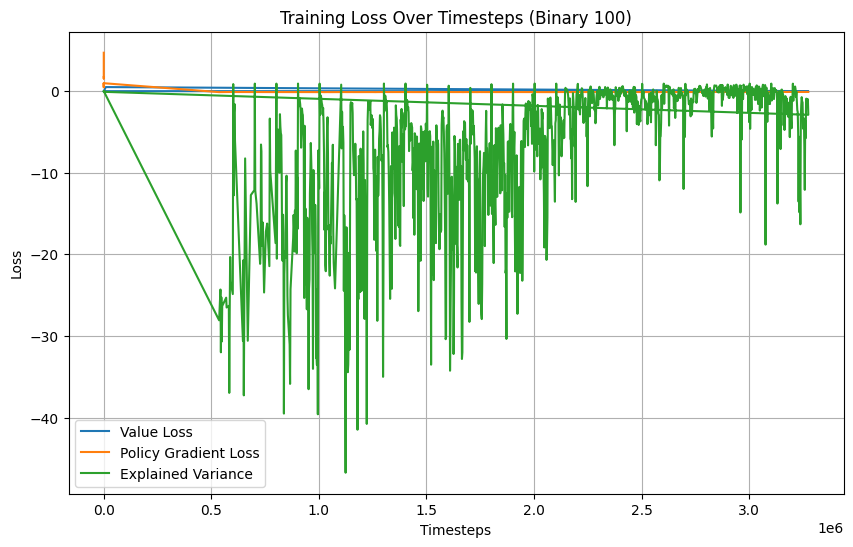

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 로그 디렉토리 정의
n_bits = 100
log_dir = f"./logs_bitflip_rnn_{n_bits}/"
os.makedirs(log_dir, exist_ok=True)

# 로그 데이터 파일 경로
log_csv_path = os.path.join(log_dir, "progress.csv")

# CSV 파일 읽기 및 그래프 그리기
if os.path.exists(log_csv_path):
    try:
        # 잘못된 줄 건너뛰기
        data = pd.read_csv(log_csv_path, on_bad_lines='skip')
        
        plt.figure(figsize=(10, 6))
        plt.plot(data["time/total_timesteps"], data["train/value_loss"], label="Value Loss")
        plt.plot(data["time/total_timesteps"], data["train/policy_gradient_loss"], label="Policy Gradient Loss")
        plt.plot(data["time/total_timesteps"], data["train/explained_variance"], label="Explained Variance")
        plt.xlabel("Timesteps")
        plt.ylabel("Loss")
        plt.title(f"Training Loss Over Timesteps (Binary {n_bits})")
        plt.legend()
        plt.grid()
        plt.show()
    except Exception as e:
        print(f"Error reading CSV file: {e}")
else:
    print("Log CSV file not found. Ensure training has completed successfully.")
